# Robust Linear Regression with PyMC3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

We use the crime dataset that appears in Statistical Methods for Social Sciences, Third Edition by Alan Agresti and Barbara Finlay (Prentice Hall, 1997).

Variables are:
- `sid`: state id
- `state`: state name
- `crime`: violent crimes per 100,000 people
- `murder`: murders per 1,000,000
- `pctmetro`: the percent of population living in metropolitan areas
- `pctwhite`: the percent of population that is white
- `pcths`: percent of population with a high school education or above
- `poverty`: percent of population living under poverty line
- `single`: percent of population that are single parents

We are going to predict `murder` using `pcths` as a predictor.

In [2]:
df = pd.read_csv('crime.csv')
df.head()

,sid,state,crime,murder,pctmetro,pctwhite,pcths,poverty,single
0,1,ak,761,9.0,41.799999,75.199997,86.599998,9.100000,14.3
1,2,al,780,11.6,67.400002,73.500000,66.900002,17.400000,11.5
2,3,ar,593,10.2,44.700001,82.900002,66.300003,20.000000,10.7
3,4,az,715,8.6,84.699997,88.599998,78.699997,15.400000,12.1
4,5,ca,1078,13.1,96.699997,79.300003,76.199997,18.200001,12.5


In [3]:
x_label = 'pcths'
x = df[x_label]
x = (x - x.mean())/x.std()

y_label = 'murder'
y = df[y_label]
y = (y - y.mean())/y.std()

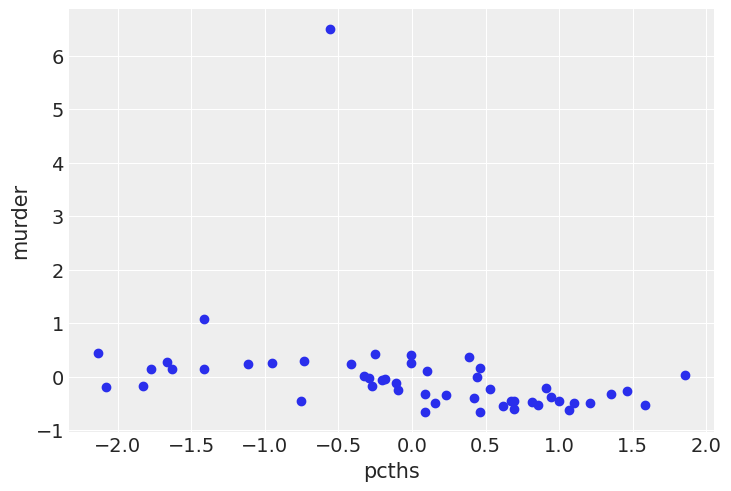

In [4]:
plt.scatter(x, y)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

Previous plot shows outliers.

## Vanilla Linear Regression

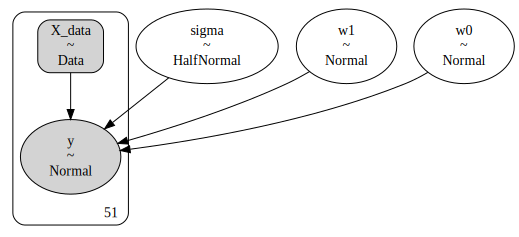

In [5]:
with pm.Model() as linreg_model:
    X_data = pm.Data("X_data", x)
    w0 = pm.Normal('w0', mu=0, sd=np.array(10))  # bias
    w1 = pm.Normal('w1', mu=0, sd=np.array(2))
    sigma = pm.HalfNormal('sigma', sd=2)
    outputs = pm.Normal('y', mu=w0 + w1*X_data, sd=sigma, observed=y)
    
pm.model_to_graphviz(linreg_model)

In [6]:
with linreg_model:
    inf_data = pm.sample(draws=2000, tune=2000, chains=2, cores=2, 
                         return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, w1, w0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [7]:
az.summary(inf_data, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,0.00,0.14,-0.26,0.28,0.0,0.0,4412.18,2412.87,1.0
w1,-0.28,0.15,-0.55,0.00,0.0,0.0,4866.50,2438.96,1.0
sigma,0.99,0.11,0.81,1.20,0.0,0.0,4325.45,2898.70,1.0


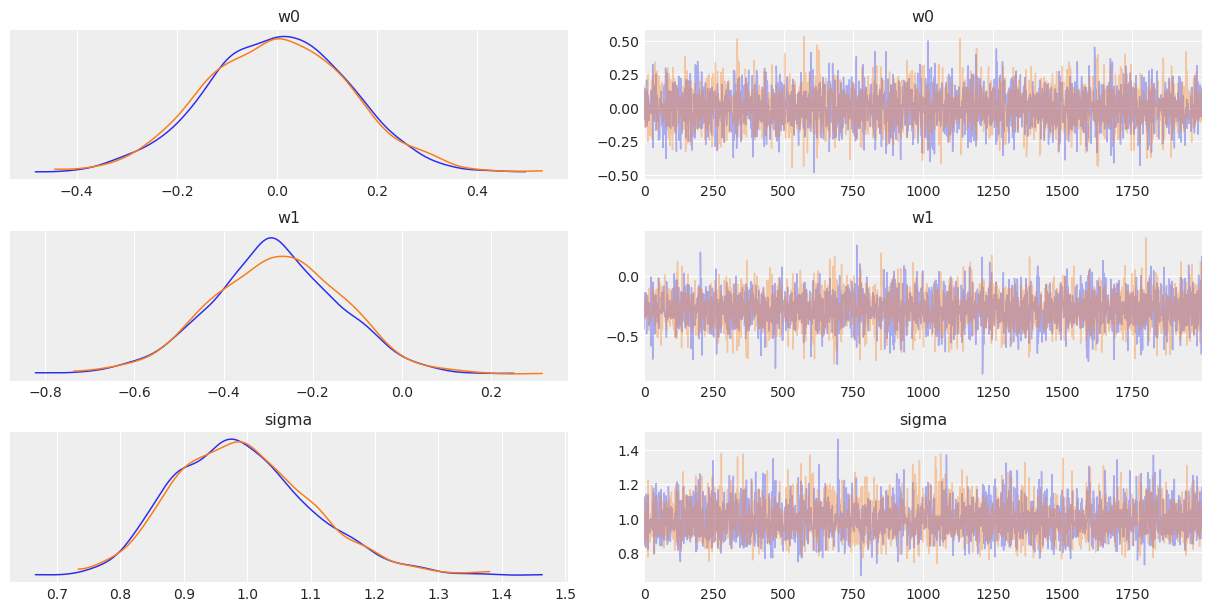

In [8]:
az.plot_trace(inf_data, compact=False);

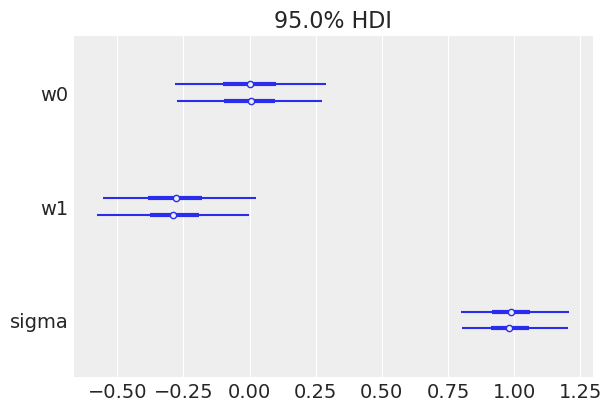

In [9]:
az.plot_forest(inf_data, hdi_prob=0.95, figsize=(6, 4));

In [10]:
w0_trace = inf_data.posterior['w0'].values.flatten()
w1_trace = inf_data.posterior['w1'].values.flatten()

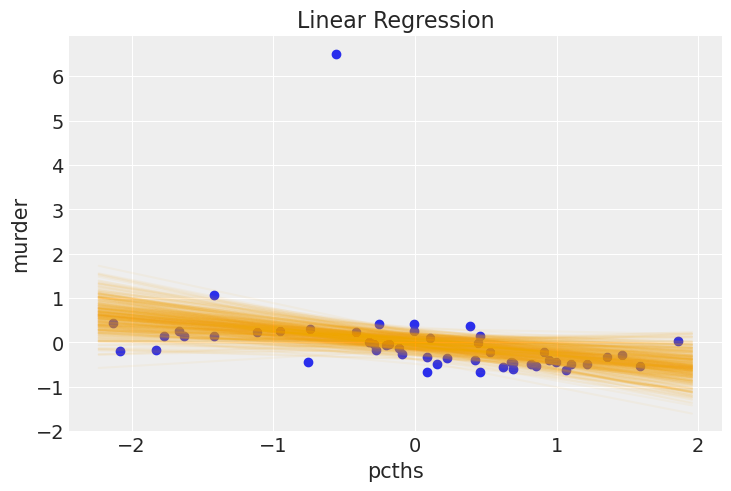

In [11]:
# samples of linear models from posterior

#plt.figure(figsize=(5,5))
plt.title('Linear Regression')
plt.scatter(x, y)
plt.xlabel(x_label)
plt.ylabel(y_label)

x_grid = np.linspace(x.min()-0.1, x.max()+0.1, 2)
for i in np.arange(0, len(w0_trace), 10):
    y_grid = w0_trace[i] + w1_trace[i]*x_grid
    plt.plot(x_grid, y_grid, color='orange', alpha=0.05)
plt.show()

## Robust Linear Regression

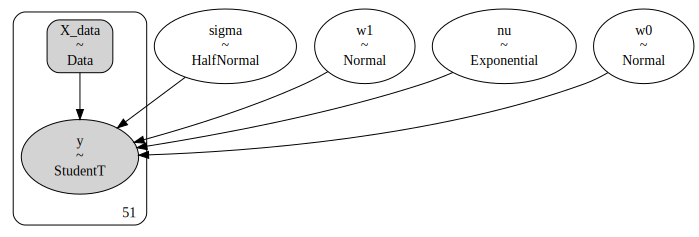

In [12]:
with pm.Model() as robust_linreg_model:
    X_data = pm.Data("X_data", x)
    w0 = pm.Normal('w0', mu=0, sd=np.array(10))
    w1 = pm.Normal('w1', mu=0, sd=np.array(2))
    sigma = pm.HalfNormal('sigma', sd=2)
    nu = pm.Exponential('nu', 1)
    outputs = pm.StudentT('y', mu=w0 + w1*X_data, sd=sigma, nu=nu, observed=y)
    
pm.model_to_graphviz(robust_linreg_model)

In [13]:
with robust_linreg_model:
    inf_data_robust = pm.sample(draws=2000, tune=2000, chains=2, cores=2, 
                         return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, w1, w0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [14]:
az.summary(inf_data_robust, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,-0.16,0.04,-0.24,-0.08,0.00,0.00,4297.98,2716.99,1.0
w1,-0.24,0.04,-0.31,-0.16,0.00,0.00,4598.19,2929.01,1.0
sigma,0.22,0.04,0.14,0.29,0.00,0.00,2863.51,2846.52,1.0
nu,1.88,0.58,0.96,2.99,0.01,0.01,2805.34,3155.80,1.0


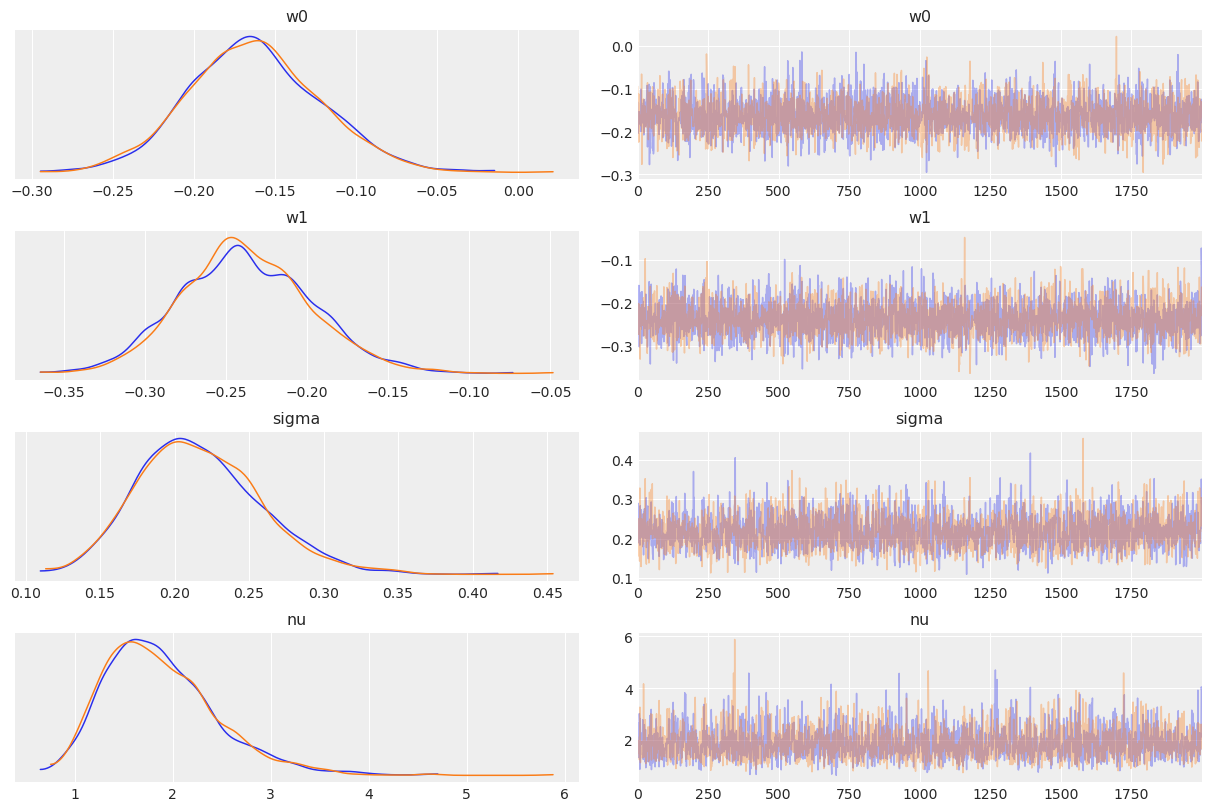

In [15]:
az.plot_trace(inf_data_robust, compact=False);

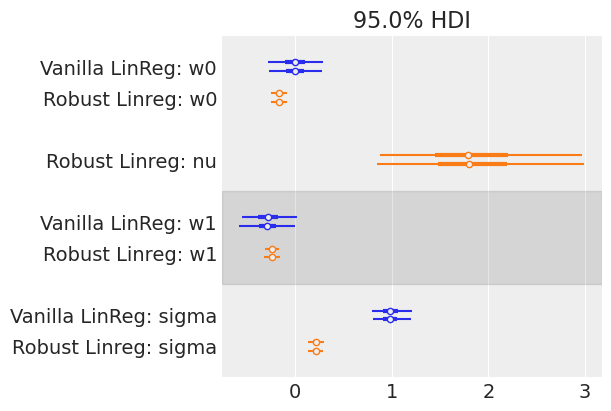

In [16]:
az.plot_forest([inf_data, inf_data_robust],
               model_names = ['Vanilla LinReg', 'Robust Linreg'],
               hdi_prob=0.95, figsize=(6, 4));

In [17]:
w0_trace_rob = inf_data_robust.posterior['w0'].values.flatten()
w1_trace_rob = inf_data_robust.posterior['w1'].values.flatten()

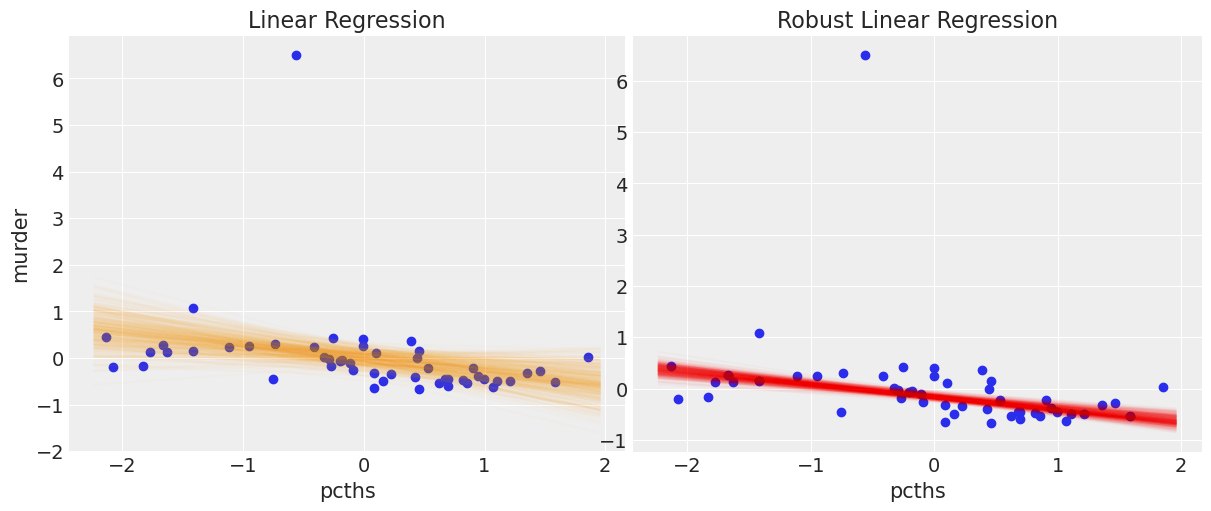

In [18]:
# samples of linear models from posterior

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.title('Linear Regression')
plt.scatter(x, y)
plt.xlabel(x_label)
plt.ylabel(y_label)
x_grid = np.linspace(x.min()-0.1, x.max()+0.1, 2)
for i in np.arange(0, len(w0_trace), 10):
    y_grid = w0_trace[i] + w1_trace[i]*x_grid
    plt.plot(x_grid, y_grid, color='orange', alpha=0.02)
    
plt.subplot(1, 2, 2)
plt.title('Robust Linear Regression')
plt.scatter(x, y)
plt.xlabel(x_label)
#plt.ylabel(y_label)
for i in np.arange(0, len(w0_trace), 10):
    y_grid = w0_trace_rob[i] + w1_trace_rob[i]*x_grid
    plt.plot(x_grid, y_grid, color='red', alpha=0.02)

plt.show()

Robust Linear Regression is more confident about weights $w_0$ and $w_1$.

In other words, it is resistant to outliers.